# Overview

This notebook contains all code and discussions for the __novice iteration__ of the research question involving __lesion coloration and malignancy__. The specific question asked is whether lesion coloration (*i.e.*, darkness or intensity) correlates with the malignancy (*i.e.*, frequency of malignant diagnoses) in any way. At the novice level, this requires data acquisition and minimal pre-processing, coupled with exploratory charts.

# Table of Contents

I. [Setup](#setup)

II. [Data Retrieval](#dr)

1. [File Access](#fa)
2. [Loading & Processing](#lp)

III. [Analysis](#anl)

1. [Naive Approach](#na)
2. [Segmentation-Conscious Approach](#sca)

IV. [Discussion](#d)

# Setup <a class="anchor" id="setup"></a>

In [a separate module](./Data_Download.ipynb), we summarized the process of downloading data from the ISIC archive through their Python tool. Recall the commands used to download images with their accompanying descriptions and segmentation information, and the locations used to store the same (outside this repository). Replace location names in the following steps as needed. 

`python download_archive.py \
--num-images=50 \ 
--images-dir ../../sample_imgs \ 
--descs-dir ../../sample_dscs -s \ 
--seg-dir ../../sample_segs --seg-skill expert`

The final setup task is to import any and all libraries needed to work with these images and populate desired results.

In [10]:
# data retrieval
import glob
import json
from PIL import Image

# data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Data Retrieval <a class="anchor" id="dr"></a>

## File Access <a class="anchor" id="fa"></a>

The `glob.glob` function enables the retrieval of all file paths matching a given pattern. A `*` in a pattern matches any amount of unspecified characters in that asterick's location. So, `*.txt` matches all file names with a `.txt` extension in the current directory. For our purposes, images are in `.jpeg` format while segmentation information is in `.png` format. The descriptions are in an extension-less JSON format. So we can retrieve all file paths as follows.

In [2]:
# get arrays of file paths for data
img_filepaths = glob.glob('../../sample_imgs/*.jp*')
seg_filepaths = glob.glob('../../sample_segs/*.png')
dsc_filepaths = glob.glob('../../sample_dscs/*')

It is useful to check that the number of files are consistent, so there are equal images, segmentations, and descriptions. It is also helpful to confirm that the first path in each of the three array correspond to the same data point, as do the second paths, and so on.

In [3]:
# verify consistent array sizes
print('Images: %d, Segmentations: %d, Descriptions: %d' % (len(img_filepaths), len(seg_filepaths), len(dsc_filepaths)))

# verify consistent ordinality
for i in range(3):
    num = i+1
    img = img_filepaths[i]
    seg = seg_filepaths[i]
    dsc = dsc_filepaths[i]
    print('\nImage #%d: %s\nSegmentation #%d: %s\nDescription #%d: %s' % (num, img, num, seg, num, dsc))

Images: 50, Segmentations: 50, Descriptions: 50

Image #1: ../../sample_imgs/ISIC_0000000.jpeg
Segmentation #1: ../../sample_segs/ISIC_0000000_expert.png
Description #1: ../../sample_dscs/ISIC_0000000

Image #2: ../../sample_imgs/ISIC_0000001.jpeg
Segmentation #2: ../../sample_segs/ISIC_0000001_expert.png
Description #2: ../../sample_dscs/ISIC_0000001

Image #3: ../../sample_imgs/ISIC_0000002.jpeg
Segmentation #3: ../../sample_segs/ISIC_0000002_expert.png
Description #3: ../../sample_dscs/ISIC_0000002


## Loading & Processing <a class="anchor" id="lp"></a>

Opening a sample image reveals each image may have wildly different color palettes (skin tone, lesion color, etc.) that will throw off analyses. Converting the image to a greyscale palette preserves the intensity of the pixel colors while reducing all color variations to shades of black and white.

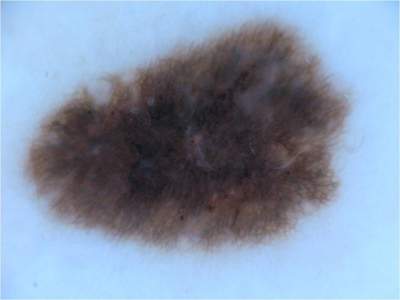

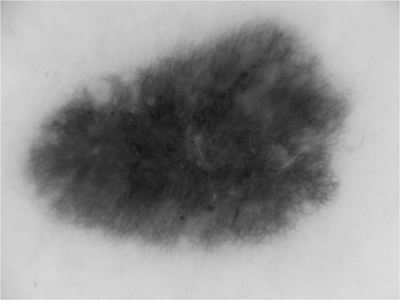

In [8]:
color = Image.open(img_filepaths[0]).resize((400,300))
greyscale = Image.open(img_filepaths[0]).resize((400,300)).convert('L')
display(color, greyscale)

All images can be similarly loaded from their filepaths, and transformed into greyscale.

In [11]:
imgs = [Image.open(x).convert('L') for x in img_filepaths]

Segmented data is data split into distinct groups. This means drawing boundaries on images, and labelling all pixels within one boundary as part of one "group", different from the other groups in the image. For images of patient skin, ISIC provides boundaries (as `.png` images) around the actual "lesion" part. The pixels inside are relevant, while the outside pixels are not.

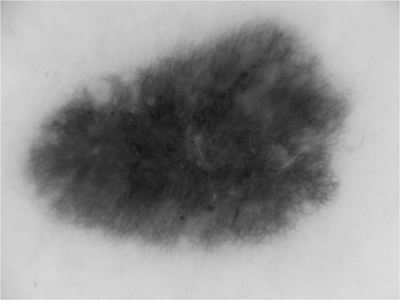

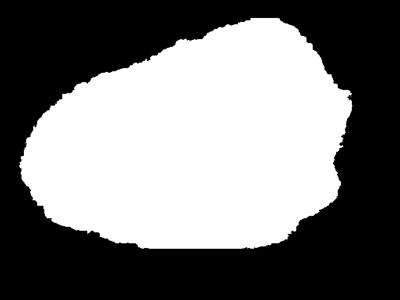

In [16]:
segment = Image.open(seg_filepaths[0]).resize((400,300))
display(greyscale, segment)

All boundary images can be loaded from the segmentation file paths.

In [18]:
segs = [Image.open(x) for x in seg_filepaths]

Both segmentation and raw images must eventually be analyzed in numeric form (e.g., as multi-dimensional arrays of pixel values). So, both can be converted to `numpy.ndarray` types.

In [27]:
np_imgs = [np.array(x) for x in imgs]
np_segs = [np.array(x) for x in segs]
np_imgs[0]

array([[254, 239, 251, ..., 250, 247, 255],
       [234, 182, 178, ..., 198, 197, 246],
       [250, 179, 161, ..., 183, 186, 250],
       ...,
       [250, 195, 187, ..., 213, 212, 251],
       [242, 193, 193, ..., 219, 214, 248],
       [253, 243, 253, ..., 250, 242, 255]], dtype=uint8)

A single description has a lot of data in a JSON object, where attribute values are identified by their attribute keys. Notice that the only attribute of interest is malignancy. The `meta` attribute value is itself a JSON object, containing *__another__* JSON object: the `clinical` attribute. The relevant `benign_malignant` flag resides here.

In [21]:
json.load(open(dsc_filepaths[0], 'r'))

{'_id': '5436e3abbae478396759f0cf',
 '_modelType': 'image',
 'created': '2014-10-09T19:36:11.989000+00:00',
 'creator': {'_id': '5450e996bae47865794e4d0d', 'name': 'User 6VSN'},
 'dataset': {'_accessLevel': 0,
  '_id': '5a2ecc5e1165975c945942a2',
  'description': 'Moles and melanomas.\nBiopsy-confirmed melanocytic lesions. Both malignant and benign lesions are included.',
  'license': 'CC-0',
  'name': 'UDA-1',
  'updated': '2014-11-10T02:39:56.492000+00:00'},
 'meta': {'acquisition': {'image_type': 'dermoscopic',
   'pixelsX': 1022,
   'pixelsY': 767},
  'clinical': {'age_approx': 55,
   'anatom_site_general': 'anterior torso',
   'benign_malignant': 'benign',
   'diagnosis': 'nevus',
   'diagnosis_confirm_type': None,
   'melanocytic': True,
   'sex': 'female'}},
 'name': 'ISIC_0000000',
 'notes': {'reviewed': {'accepted': True,
   'time': '2014-11-10T02:39:56.492000+00:00',
   'userId': '5436c6e7bae4780a676c8f93'},
  'tags': ['Challenge 2018: Task 1-2: Training',
   'Challenge 2019:

This item (and only this item) can be extracted from each file path that is loaded. Note that the resulting array of benign/malignant flags still maintain their relative ordering to the arrays of images, segmentations, etc.

In [23]:
dscs = [json.load(open(x, 'r')) for x in dsc_filepaths]
malignancy_flags = [x['meta']['clinical']['benign_malignant'] for x in dscs]

# Analysis <a class="anchor" id="anl"></a>

## Naive Approach <a class="anchor" id="na"></a>

Correlating color with malignancy requires boiling down the images to numeric values. The arithmetic mean of all pixels in the greyscale `numpy` array can be used to represent overall "intensity" or "darkness" of the lesion. If the mean approaches 0, that means pixel values are approaching 0 (representing darker, closer-to-black images). If the mean is high, that means the greyscale image is lighter overall.

This approach is naive because it does not account for the segmented boundaries. The higher pixel values outside the lesion area (representing more lightness) may inflate the mean of the entire image, even if the small relevant area is pretty dark. Still, the average intensities for each image can be calculated. 

In [40]:
naive_intensities = [np.mean(x) for x in np_imgs]

We can simply correlate the means to the malignancy diagnosis for the images with a scatter-plot.

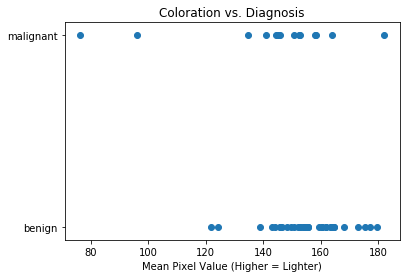

In [46]:
plt.scatter(naive_intensities, malignancy_flags)
plt.xlabel('Mean Pixel Value (Higher = Lighter)')
plt.title('Coloration vs. Diagnosis')
plt.show()

There are some issues with this plot. First, as mentioned previously, the lack of boundary information includes a lot of irrelevant skin pixels. Imagine a pale-skinned patient distorting the correlation between image lightness and malignancy, because most of the image is of their unblemished surrounding area. 

The second issue is that there are only two diagnoses: malignant and benign. These data points are clustered in two lines, and it becomes very difficult to tell how the points are spread by their different intensities, especially as the dataset gets larger. So, we can use a violin plot to replace these "lines" of dots with distribution plots for benign and malignant lesions, showing us the shape of the coloration data for the two diagnoses.

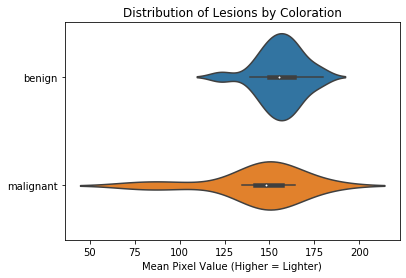

In [50]:
sns.violinplot(naive_intensities, malignancy_flags)
plt.xlabel('Mean Pixel Value (Higher = Lighter)')
plt.title('Distribution of Lesions by Coloration')
plt.show()

## Segmentation-Conscious Approach <a class="anchor" id="sca"></a>

The analysis here is identical, only we reduce the greyscale arrays to only those pixels that the segmentation boundaries tell us are actually inside the lesion areas. This reduction step leverages indexing capabilities with `numpy`. The drawn boundaries are black (0-valued) outside the lesion, and white (non-0) inside. So, for every data point:

- find the indexes (locations) in the segmented `numpy` arrays, where the value is non-0 (representing the relevant area)
- access only these locations in the greyscale `numpy` arrays
- take the mean of these lesion-only parts of the greyscale arrays
- store these means

In [53]:
segmented_intensities = []
for i in range(len(np_imgs)):
    idxs = np.where(np_segs[i])
    img_rdx = np_imgs[i][idxs]
    segmented_intensities.append(np.mean(img_rdx))

Now we can redo our initial scatter-plot.

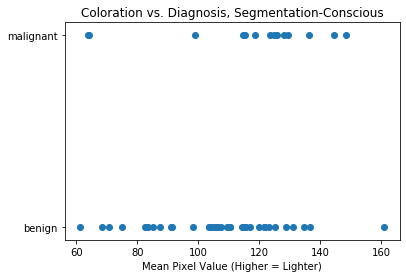

In [55]:
plt.scatter(segmented_intensities, malignancy_flags)
plt.xlabel('Mean Pixel Value (Higher = Lighter)')
plt.title('Coloration vs. Diagnosis, Segmentation-Conscious')
plt.show()

Which is similarly difficult to understand. The violin plot follows.

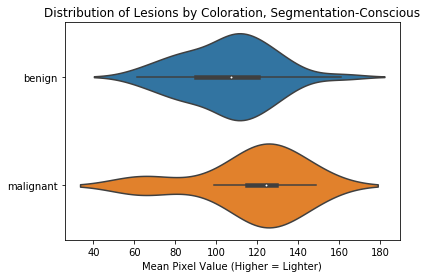

In [56]:
sns.violinplot(segmented_intensities, malignancy_flags)
plt.xlabel('Mean Pixel Value (Higher = Lighter)')
plt.title('Distribution of Lesions by Coloration, Segmentation-Conscious')
plt.show()

# Discussion <a class="anchor" id="d"></a>

__Comments on coloration-malignancy correlation__

*Feel free to use this area to form conclusions on the results of the analyses as they relate to the research question.*

__Comments on data quality and skew__

*Additional notes.*

__Comments on impact of segmentation__

*Additional notes.*